# Investigating the used motorcycle market with Craigslist
### A dealership startup case study
#### Faced with slimming margins and increased consumer reliance on private sales, how can motorcycle dealerships tailor their offerings to best match market demand?  Which makes, models, bike classes, and locations have the highest profit potential?
In the current upswing of the US economy, more people are buying motorcycles. Of all states, California boasted the largest number of new motorcycle sales in 2015 at nearly 80,000 or roughly 14% of the national total. While private sale data is less widely available, the private market is largely believed to have followed suit.  Dealerships have historically focused on the sale of new and lightly used motorcycles, yet many consumers favor the older, more affordable offerings available on the private market.  This preference has been amplified by recent socioeconmic trends such as the 2008 recession, and the tendency for a new wave of younger buyers to seek cheaper offerings. While established dealers tend to ignore older bike sales as a source of revenue, small, independent dealers have begun to fill this niche by offering older, cheaper bikes for sale.  The high volume of this segment has allowed these small dealers to flourish. Should big dealers follow suit by focusing less on new bike sales and modeling their showrooms after the private market?  And in the hypothetical scenario of a new dealership startup, which locations, makes, models, etc. have the highest room for dealer growth?

### Building a fast, fault-tolerant Craigslist scraper
Craigslist is the preeminent online marketplace for both private and dealer-based motorcycle sales.  As such, it provides a unique platform to compare both motorcycle markets with a single database. It is especially valuable as a source of private-party sale information, which is not as widely available as dealer data. Craigslist posts can contain a wealth of information for each posting, including, make, model, year, mileage, condition, engine displacement, location, and more. Extraction of this data can enable the side-by-side comparison of dealer and private listings along any combination of these features.

Craigslist offers little in the way of formatted, ready-to-use data. However, many of the aforementioned post features can be extracted by their HTML tags.  A web scraper can search through all appropriate postings, pulling out the requisite data.
My web scraper was built to do the following:
- Using the Requests library, get a 'directory' of URLs for each geographical region of interest; for each search, iterate through all pages of search results and compile a list of posting URLs
- Using Beautifulsoup, parse each HTML page and, using tag identities for each element of interest, grab URLs, post titles, and other info from each posting
- Using asyncio, send a batch of asynchronous requests to dramatically speed up execution by avoiding the request->wait->response bottleneck
- Using pandas, format all extracted information as a dataframe and save for later use


In [5]:
import requests
import sys
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import cProfile, pstats, io
import asyncio
import aiofiles
import aiohttp



def get_url(url):   # get requested URL and return parsed HTML doc   
    resp = requests.get(url, timeout=3)
    resp.raise_for_status()
    doc = parse_source(resp.content, resp.encoding)
    return doc

def parse_source(html, encoding='utf-8'): # parse HTML with BeautifulSoup
    
    parsed = BeautifulSoup(html, "lxml", from_encoding=encoding)
    return parsed

def write_html(txt,filename="C:/Users/asdasdasd/test3.html"): # write HTML to file
    
    html_file = open(filename,"w")
    html_file.write(txt)
    html_file.close()
    return None

# get posting URLs in search results page
def find_links(soup):
    
    spans = soup.find_all('a',{'class' : 'result-title hdrlnk'})
    links = [span['href'] for span in spans]
    return links

# iterate through all pages of search results, return single list of post URLs
# can work with multiple or single regions
def get_all_links(regions): 
    
    total_list = []
    for region in regions:  #https://auburn.craigslist.org/
        print('Collecting URLs from %s...' % region)
        city_url = '%ssearch/mcd' % (region)   # /mcy for owner, /mcd for dealer
        doc = get_url(city_url)
        n = get_result_num(doc)
        if n==None:
            return None
        
        num = float(n)

        a = np.arange(0,num,120) # 120 listings per page
        url_list = []
        for i in range(len(a)):
            print('Getting page %d of %d...' % (i,len(a))) 
            url_try = '%s?=%d' % (city_url,a[i])
            doc = get_url(url_try)
            links = find_links(doc)
            url_list.append(links)  
            
        total_list.append(url_list)
        
    flat_list_1 = [item for sublist in total_list for item in sublist]
    flat_list_2 = [item for sublist in flat_list_1 for item in sublist]
    print('Done!')
    return flat_list_2

# get all subregions in specified state using craigslist home page
def get_region(state='California'): 
    print(state)
    doc = get_url('https://www.craigslist.org/about/sites')
    a = doc.find_all('h4') # get state tags
    b = [aa.get_text() for aa in a] # get state strings
    #print(b)
    c = doc.find_all('ul') # get city listing block
    #print(c)
    indices = [i for i, s in enumerate(b) if state in s] # get index corresponding to input state
    #print(indices)
    d = c[indices[0]].find_all('a') # get link tags
    cities = [span['href'] for span in d] # get link URLs
    return cities
    
# get prices for each posting - can use to check post validity
def get_prices(soup):
    
    spans = soup.find_all('span', {'class' : 'result-price'})
    lines = [span.get_text() for span in spans]
    #print(lines)
    return lines

# get number of results from subregion search
def get_result_num(soup):
    
    spans = soup.find_all('span', {'class' : 'totalcount'})
    result = [span.get_text() for span in spans]
    try:
        result_num = result[1]
    except:
        return None
    print(result_num)
    return result_num

# reference list for fields to be included in initial dataframe
key_list = set(['price','post title','make','model','year','condition: ','engine displacement (CC): ','latitude','longitude',
                'odometer: ','title status: ','url'])

# extract make/model info through string similarity - fault tolerant, currently unused
# def parse_title(title,str_list=str_list):
    
#     score=list()
#     for str in str_list:
#         str_score = SequenceMatcher(None, str.lower(), title.lower()).ratio() # make lowercase and compare strings
#         score.append(str_score)
#     ind = np.argmax(score)
#     return str_list[ind]

# if first 4 characters of title string are int, and is in specified range, then extract as year
def get_year(title):  
    
    ints = [int(s) for s in title.split() if s.isdigit()]
    try:
        year = ints[0]
    except:
        return None
    if 1900 <= year <= 2019:  # find valid year
        return year
    else:
        return None

# find each extracted value and match to reference key list; if value not found, insert 0
def normalize_dict(d,set1=key_list): #match dict values to list of possible keys and format into dataframe
    
    set2 = set(d.keys())
    notInSet2 = set1.difference(set2)
    inSet2 = set2.intersection(set1)
    d2 = {e:d.get(e) for e in inSet2}
    d3 = dict.fromkeys(set1,0)
    d3.update(d2)
    return d3

# parse listing and return normalized dict of scraped data
def check_listing_async(doc,url): 

    try:
        price_span = doc.find('span',{'class' : 'price'})  #find price - if no price, move to next URL
        s = price_span.get_text()
    except:
        return None
    price = int(s[1:len(s)])  # delete $ and convert to int
    titles = ['price']   # initialize dictionary
    values = [price]
    titles.append('url')
    values.append(url)
    try:   # see if location data exists
        ydivs = doc.find("div", {"class": "viewposting"})
        lat = float(ydivs['data-latitude'])
        long = float(ydivs['data-longitude'])
        values.append(lat)
        values.append(long)
        titles.append('latitude')
        titles.append('longitude')      
    except:
        ydivs=[]
    spans = doc.find_all('b')
    title_span = spans[0]
    title_test = title_span.previous_sibling
    if title_test==None:  # changed post title identification to handle multiple None fields (dealer posts)
            value_append = title_span.text
            values.append(value_append)
            titles.append('post title')            
    for span in spans:       
        title = span.previous_sibling #find dict key for value
        if title!=None:   # flag for make/model --- need to parse
            titles.append(title)
            values.append(span.text)        
    d = dict(zip(titles,values))
    d2 = normalize_dict(d)
    return d2

# asynchronous url fetch
async def fetch(session, url):
    async with session.get(url) as response:
        return await response.text()
    
# asynchronous url batch request - return list of dicts from each post
async def fetch_all(session, urls, loop):
    results = await asyncio.gather(
        *[fetch(session, url) for url in urls],
        return_exceptions=True  # default is false, that would raise
    )
    doc = parse_source(str(results))
    d2=[]
    count=1
    for i in range(len(results)):
        doc = parse_source(str(results[i]))
        d = check_listing_async(doc,urls[i])         
        count+=1
        if count%100==0:
            print('Scraping post %d of %d...' % (count,len(urls)))
        if d!=None:
            d2.append(d)

    return d2

# # unused
# def make_dataframe(doc):   # iterate through links and make dataframe of results
#     links_out = find_links(doc)   # for single base URL
#     #links_out = get_nationwide_links()
#     d=[]
    
#     count=1
#     total=len(links_out)
#     for link in links_out:
#         d1 = check_listing(link)
#         if d1!=None:
#             d.append(d1)
#             count=count+1
#             if count%10==0:
#                 print('Scraping post %d of %d...' % (count,total))  
#     df = pd.DataFrame(d)
#     return df
# # unused
# def make_dataframe_async(doc):   # iterate through links and make dataframe of results
#     links_out = find_links(doc)   # for single base URL
#     #links_out = get_nationwide_links()
#     d=[]
#     loop = asyncio.get_event_loop()
#     loop.run_until_complete(
#         asyncio.gather(
#             *(check_listing_async(*link) for link in links_out)
#         )
#     )
#     loop.close()
#     return None

# asynchronous scrape for list of URLs
def scrape_region_async(url_list): # call get_all_links first
    loop = asyncio.get_event_loop()
    session = aiohttp.ClientSession(loop=loop)
    d = loop.run_until_complete(
        fetch_all(session, url_list, loop))
    e = [x for x in d if x is not None]
    return d

# get all nationwide postings - currently unused
# def get_nationwide_links():
#     city_list = get_all_regions()
#     url_list=[]
#     for city in city_list:
#         urls = get_all_links(city)
#         url_list.append(urls)
#     return url_list
    
    
    
################################################################################################################
#####################################################################################################


In [981]:

###########

if __name__ == '__main__':
    
#    if len(sys.argv) > 1 and sys.argv[1] == 'test':  # for command line
#        html, encoding = read_search_results()
#    else:

    #################### scrape all results in specified state ####################   
    flat_list = get_region('Minnesota')
    d2=[]
    #print(flat_list)
    for city in flat_list:
        url_list = get_all_links([city])
        if url_list!=None:           
            d = scrape_region_async(url_list)
            d2.append(d)
    d3 = [item for sublist in d2 for item in sublist] #flatten list
    df = pd.DataFrame(d3) 
    ###############################################################################
    
    
    filename="C:/Users/sam/jupyter/links.html"
    filename_all = "C:/Users/sam/jupyter/results.html"
    url_test = "https://sfbay.craigslist.org/eby/mcy/d/suzuki-gs500f-2003/6550035515.html"
    ###########################################################################################
    # do async requests

    
    # enable profiling
    #pr = cProfile.Profile()
    #pr.enable()
    
    #d3 = check_listing_async(url_test)
    
    #loop = asyncio.get_event_loop()  # core asyncio loop
    #session = aiohttp.ClientSession(loop=loop)
    #d = loop.run_until_complete(
    #    fetch_all(session, urls, loop))

    #df = pd.DataFrame(d)
    #df
    
    #df = make_dataframe_async(doc)
    
    #pr.disable()
    #s = io.StringIO()
    #sortby = 'cumulative'
    #ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    #ps.print_stats()
    #print(s.getvalue())

    #print('Writing...')
    #df.to_pickle('C:/Users/sam/jupyter/results.pkl')
    
    
    #df
    #links_out = find_links(doc)
    #a = get_all_links()
    
    #prices = get_prices(doc)   remove this
    #result_num = get_result_num(doc)
    

    #print(links_out[1])
    #listing_Test = check_listing(url_test)
    #print(listing_Test)

    
    #file = open(filename, 'wb')
    #for link in links_out:
    #    href = link.get('href') +'\n'
    #    file.write(href.encode())
    #    link_now = link + '\n'
    #    print(href)
    #    file.write(link_now.encode())
    #for price in prices:
    #    price_now = price + '\n'
    #    file.write(price_now.encode())
    #file.close()
    
    # useful lines? from initial search
    # <time class="result-date" datetime="2018-04-08 19:43" title="Sun 08 Apr 07:43:37 PM">
    # <span class="result-hood">\n          (hayes valley)\n 
    
    # from clicking on listing
    # <input class="multi_checkbox" id="auto_title_status_2" name="auto_title_status" type="checkbox" value="2"/>\n
    # salvage\n         check box - 2 for salvage, 1 for clean title?
    #159.65.110.167 3128
    #print(find_links(doc))
    #with open("output1.html", "w") as file:
    #    file.write(str(doc_out))
    #    file.close()
    #with open(filename_all, "w") as file:
    #    file.write(str(listing_Test))
    #    file.close()
   # write_html(doc_out,"C:/Users/asdasdasd/test.html")

Minnesota
20
Getting page 0 of 1...
Done!


C:\Users\sam\Anaconda3\lib\site-packages\bs4\__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


Scraping post 100 of 120...


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000000026675400>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x000000002EFDF128>, 437837.491), (<aiohttp.client_proto.ResponseHandler object at 0x000000002FE460F0>, 437837.491), (<aiohttp.client_proto.ResponseHandler object at 0x0000000014E98048>, 437837.491), (<aiohttp.client_proto.ResponseHandler object at 0x00000000262EA0B8>, 437837.491), (<aiohttp.client_proto.ResponseHandler object at 0x00000000262EAEB8>, 437837.507), (<aiohttp.client_proto.ResponseHandler object at 0x00000000262EAB38>, 437837.507), (<aiohttp.client_proto.ResponseHandler object at 0x000000002FE467F0>, 437837.522), (<aiohttp.client_proto.ResponseHandler object at 0x00000000262EA160>, 437837.538), (<aiohttp.client_proto.ResponseHandler object at 0x0000000048C84EB8>, 437837.538), (<aiohttp.client_proto.ResponseHandler object at 0x000000002FE46160>, 437837.538), (<aiohttp.client_proto.ResponseHand

3
Getting page 0 of 1...
Done!
Scraping post 100 of 120...


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000000002F909630>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x000000002BFF9048>, 437848.38), (<aiohttp.client_proto.ResponseHandler object at 0x000000002BFF9080>, 437848.489)]', '[(<aiohttp.client_proto.ResponseHandler object at 0x000000002BFF9E10>, 437848.38), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A53C898>, 437848.411)]', '[(<aiohttp.client_proto.ResponseHandler object at 0x0000000042D4F780>, 437848.38), (<aiohttp.client_proto.ResponseHandler object at 0x0000000022246550>, 437848.38), (<aiohttp.client_proto.ResponseHandler object at 0x0000000022246080>, 437848.38), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049C95198>, 437848.38), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049C95860>, 437848.38), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049C95780>, 437848.38), (<aiohttp.client_proto.ResponseHand

12
Getting page 0 of 1...
Done!
Scraping post 100 of 120...


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000000030A2F2B0>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x000000002A5676A0>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A567860>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A567780>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A5679E8>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A567550>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A567C18>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A5677B8>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A567F98>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A5673C8>, 437858.442), (<aiohttp.client_proto.ResponseHandler object at 0x000000002A567630>, 437858.442), (<aiohttp.client_proto.ResponseHand

12
Getting page 0 of 1...
Done!
Scraping post 100 of 120...


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000000037172860>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x000000003C797AC8>, 437868.972), (<aiohttp.client_proto.ResponseHandler object at 0x000000003C797FD0>, 437868.972), (<aiohttp.client_proto.ResponseHandler object at 0x000000001A620EB8>, 437868.972), (<aiohttp.client_proto.ResponseHandler object at 0x0000000027A5A438>, 437868.972), (<aiohttp.client_proto.ResponseHandler object at 0x000000001BE56390>, 437868.972), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049BECF98>, 437868.972), (<aiohttp.client_proto.ResponseHandler object at 0x000000002D357DD8>, 437868.972), (<aiohttp.client_proto.ResponseHandler object at 0x000000002D357128>, 437868.972), (<aiohttp.client_proto.ResponseHandler object at 0x000000003C797E48>, 437869.003), (<aiohttp.client_proto.ResponseHandler object at 0x000000003C797A58>, 437869.003), (<aiohttp.client_proto.ResponseHand

1075
Getting page 0 of 9...
Getting page 1 of 9...
Getting page 2 of 9...
Getting page 3 of 9...
Getting page 4 of 9...
Getting page 5 of 9...
Getting page 6 of 9...
Getting page 7 of 9...
Getting page 8 of 9...
Done!
Scraping post 100 of 1080...
Scraping post 200 of 1080...
Scraping post 300 of 1080...
Scraping post 400 of 1080...
Scraping post 500 of 1080...
Scraping post 600 of 1080...
Scraping post 700 of 1080...
Scraping post 800 of 1080...
Scraping post 900 of 1080...
Scraping post 1000 of 1080...


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000000002AD45940>


53
Getting page 0 of 1...
Done!
Scraping post 100 of 120...


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000000001A94FFD0>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x00000000372F74E0>, 437941.762), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F7898>, 437941.762), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F7160>, 437941.762), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F7518>, 437941.762), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F73C8>, 437941.762), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F7A20>, 437941.762), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F7C88>, 437941.793), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F7470>, 437941.793), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F72E8>, 437941.793), (<aiohttp.client_proto.ResponseHandler object at 0x00000000372F7E80>, 437941.793), (<aiohttp.client_proto.ResponseHand

15
Getting page 0 of 1...
Done!
Scraping post 100 of 120...


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000000002DD70630>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1A8D0>, 437951.996), (<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1AF98>, 437952.012)]', '[(<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1A7F0>, 437951.996), (<aiohttp.client_proto.ResponseHandler object at 0x000000002DD707F0>, 437952.027)]', '[(<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1AB00>, 437951.996), (<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1AA20>, 437951.996), (<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1A908>, 437951.996), (<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1A2B0>, 437952.012), (<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1AA90>, 437952.012), (<aiohttp.client_proto.ResponseHandler object at 0x0000000016F1A940>, 437952.012), (<aiohttp.client_proto.Resp

67
Getting page 0 of 1...
Done!
Scraping post 100 of 120...


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x000000002AFC91D0>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x000000002AE505F8>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x000000002AE50A90>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049A11588>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049A11048>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x000000002AE50940>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x000000002AE50128>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049A11940>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049A11898>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x0000000049A11C18>, 437968.111), (<aiohttp.client_proto.ResponseHandler object at 0x000000002AE50710>, 437968.111), (<aiohttp.client_proto.ResponseHand

### Read dataframes for each search

In [8]:
df_owner = pd.read_pickle('C:/Users/asdasdasd/cl-scraper/CA_by_owner.pkl')
df_dealer = pd.read_pickle('C:/Users/asdasdasd/cl-scraper/CA_dealer.pkl')
df_owner.head(10)

,condition:,engine displacement (CC):,latitude,longitude,make,model,odometer:,post title,price,title status:,url,year
0,like new,0,36.427564,-121.331015,0,0,13000,2015 Harley-Davidson,16500,clean,https://bakersfield.craigslist.org/mcy/d/2015-...,0
1,like new,103,35.339600,-119.021800,0,0,36906,2013 harley davidson,16500,clean,https://bakersfield.craigslist.org/mcy/d/2013-...,0
2,0,0,35.410472,-119.026718,0,0,0,2005 ironhorse chooper,3000,0,https://bakersfield.craigslist.org/mcy/d/2005-...,0
3,excellent,1500,35.148200,-119.455700,0,0,20348,1991 kawasaki vulcan 1500,2500,clean,https://bakersfield.craigslist.org/mcy/d/1991-...,0
4,excellent,0,0.000000,0.000000,0,0,0,2002 Honda xr70,920,0,https://bakersfield.craigslist.org/mcy/d/2002-...,0
5,0,0,35.163260,-119.046324,0,0,0,willys jeep,15000,0,https://bakersfield.craigslist.org/mcy/d/stree...,0
6,like new,0,35.132200,-118.449000,0,0,2903,Kawasaki Vulcan 900 Classic,3800,0,https://bakersfield.craigslist.org/mcy/d/2006-...,0
7,new,1000,0.000000,0.000000,0,0,2400,2012 bmw s1000rr,13000,clean,https://bakersfield.craigslist.org/mcy/d/bmw-s...,0
8,new,0,33.799100,-117.995600,0,0,0,2007 Honda 919,5000,clean,https://bakersfield.craigslist.org/mcy/d/2007-...,0
9,good,0,35.463637,-118.789785,0,0,0,1969 Bonanza BC 1500 Modified,750,0,https://bakersfield.craigslist.org/mcy/d/1969-...,0


### Filling in the data - parsing post titles into make, model, year, and post area
Craigslist post titles may contain make, model, and year information.  Any of these can be absent, so accurate parsing relies on unambiguous determination of each component.
- Year information is displayed first if present, and so searching for a leading 4-number string can extract this component
- Removal of the year and remaining non-alphanumeric characters leaves make and model information.  A list of known makes can be used to cross reference each post. 
- Make information must exactly match the refernce list; a similarity score was originally used to provide tolerance to typos, but this led to false matches, as well as model information being interpreted as make, especially with shorter makes (KTM, EBR, BMW, etc.)
- If found, the make is removed from the string, and the remaining information is left as the model. This is due to the high overhead of manually creating a list of all possible models for all makes, as well as the potential of users posting a variety of strings for the same model (e.g. yzfr6, yzf600r, r6)
- Post area can be easily parsed from the post URL, with the form http://(area).craigslist.org/etc

In [18]:
import re


def parse_title_list(df):   
    
    title_list = df['post title'].tolist()
    year_list= []
    model_list = []
    make_list = []

    for title in title_list:
        try:
            year,str_test = get_year(title)
        except:
            year=None
            str_test=title
        make, model = get_make(format_string(str_test))
        year_list.append(year)
        make_list.append(make)
        model_list.append(model)


    return year_list, make_list, model_list


make_list = ['Suzuki','Kawasaki','Honda','HarleyDavidson','Harley',
            'Yamaha','Triumph','Aprilia','Ducati','Buell','BMW',
            'Cagiva','Derbi','Husaberg','Husqvarna',
            'Hyosung','Indian','KTM','MotoGuzzi','MV Agusta',
            'Norton','Piaggio']


def format_string(string):
    a = re.sub(r'\W+', '',''.join(string))  # exclude all alphanumeric characters and spaces
    return a.lower()

def get_year(title):  
    try:
        ints = [int(s) for s in title.split() if s.isdigit()]
        year = ints[0]
    except:
        return None
    if 1900 <= year <= 2019:  # find valid year
        return year, re.sub(r'\W+', '',''.join(title.split()[1:])) 
    else:
        return None

def get_make(str_test,make_list=make_list): # extracts make and returns remainder string
    if str_test==None:
        return None
    score = []
    highscore=0
    make_out = None
    idx_out = 0
    for make in make_list:
        idx_start = str_test.find(make.lower())
        if idx_start>=0:
            score = len(make)
            if score>highscore:
                highscore=score
                make_out = make
                idx_out = idx_start
    if make_out=='HarleyDavidson':
        make_out='Harley'
    return make_out, str_test[highscore+idx_out:]

def get_post_area(df):
    url_list = df['url'].tolist()
    area_list = []
    for url in url_list:
        a = url.find('/')
        b = url.find('.')
        area = url[a+2:b]
        area_list.append(area)
    return area_list


# https://bakersfield.craigslist.org/mcy/d/2013-harley-davison/6553166695.html

# testing
def process_post_titles(df):
    
    year_list, make_list, model_list = parse_title_list(df)
    area_list = get_post_area(df)
    dat2 = pd.DataFrame({'area': area_list})
    df['year']=year_list
    df['make']=make_list
    df['model']=model_list
    df2 = df.join(dat2)
    return df2

df_p_owner = process_post_titles(df_owner)
df_p_dealer = process_post_titles(df_dealer)

df_p_owner.head(10)

      



,condition:,engine displacement (CC):,latitude,longitude,make,model,odometer:,post title,price,title status:,url,year,area
0,like new,0,36.427564,-121.331015,Harley,,13000,2015 Harley-Davidson,16500,clean,https://bakersfield.craigslist.org/mcy/d/2015-...,2015.0,bakersfield
1,like new,103,35.339600,-119.021800,Harley,,36906,2013 harley davidson,16500,clean,https://bakersfield.craigslist.org/mcy/d/2013-...,2013.0,bakersfield
2,0,0,35.410472,-119.026718,None,ironhorsechooper,0,2005 ironhorse chooper,3000,0,https://bakersfield.craigslist.org/mcy/d/2005-...,2005.0,bakersfield
3,excellent,1500,35.148200,-119.455700,Kawasaki,vulcan1500,20348,1991 kawasaki vulcan 1500,2500,clean,https://bakersfield.craigslist.org/mcy/d/1991-...,1991.0,bakersfield
4,excellent,0,0.000000,0.000000,Honda,xr70,0,2002 Honda xr70,920,0,https://bakersfield.craigslist.org/mcy/d/2002-...,2002.0,bakersfield
5,0,0,35.163260,-119.046324,None,willysjeep,0,willys jeep,15000,0,https://bakersfield.craigslist.org/mcy/d/stree...,NaN,bakersfield
6,like new,0,35.132200,-118.449000,Kawasaki,vulcan900classic,2903,Kawasaki Vulcan 900 Classic,3800,0,https://bakersfield.craigslist.org/mcy/d/2006-...,NaN,bakersfield
7,new,1000,0.000000,0.000000,BMW,s1000rr,2400,2012 bmw s1000rr,13000,clean,https://bakersfield.craigslist.org/mcy/d/bmw-s...,2012.0,bakersfield
8,new,0,33.799100,-117.995600,Honda,919,0,2007 Honda 919,5000,clean,https://bakersfield.craigslist.org/mcy/d/2007-...,2007.0,bakersfield
9,good,0,35.463637,-118.789785,None,bonanzabc1500modified,0,1969 Bonanza BC 1500 Modified,750,0,https://bakersfield.craigslist.org/mcy/d/1969-...,1969.0,bakersfield


In [19]:
df_p_dealer.head(10)

,condition:,engine displacement (CC):,latitude,longitude,make,model,odometer:,post title,price,title status:,url,year,area
0,0,779,33.948286,-118.369782,Yamaha,fz8,13769,2012 Yamaha FZ8,4995,clean,https://bakersfield.craigslist.org/mcd/d/2012-...,2012.0,bakersfield
1,0,1,33.948286,-118.369782,Harley,streetbob,3495,2016 Harley-Davidson Street Bob®,12995,clean,https://bakersfield.craigslist.org/mcd/d/2016-...,2016.0,bakersfield
2,0,0,0.000000,0.000000,Harley,flstcheritag,0,2017 Harley-Davidson FLSTC - Heritag,16991,clean,https://bakersfield.craigslist.org/mcd/d/2017-...,2017.0,bakersfield
3,0,0,0.000000,0.000000,Suzuki,gsx1300rzhayabusa,26023,2006 Suzuki GSX1300RZ - HAYABUSA,5995,clean,https://bakersfield.craigslist.org/mcd/d/2006-...,2006.0,bakersfield
4,0,749,33.948286,-118.369782,Suzuki,gsxs750z,13347,2015 Suzuki GSX-S750Z,5495,clean,https://bakersfield.craigslist.org/mcd/d/2015-...,2015.0,bakersfield
5,0,1,33.948286,-118.369782,KTM,1290superduker,5254,2015 KTM 1290 Super Duke R,11495,clean,https://bakersfield.craigslist.org/mcd/d/2015-...,2015.0,bakersfield
6,0,0,0.000000,0.000000,Harley,flhtcutgtri,0,2016 Harley-Davidson FLHTCUTG - Tri,29992,clean,https://bakersfield.craigslist.org/mcd/d/2016-...,2016.0,bakersfield
7,0,0,0.000000,0.000000,MotoGuzzi,audace,2350,2016 Moto Guzzi AUDACE,9995,clean,https://bakersfield.craigslist.org/mcd/d/2016-...,2016.0,bakersfield
8,0,103,33.948286,-118.369782,Harley,street,15987,2014 Harley-Davidson Street,16495,clean,https://bakersfield.craigslist.org/mcd/d/2014-...,2014.0,bakersfield
9,0,1,33.948286,-118.369782,BMW,r1200gs,28666,2016 BMW R 1200 GS,12995,clean,https://bakersfield.craigslist.org/mcd/d/2016-...,2016.0,bakersfield


### Map make and model to displacement and bike type
#### - Get list of common bike models
#### - Define mapping of each model to displacement and type
The number of possible models, along with variations in how model names are written in post titles, makes quantification by specific model difficult. Additionally,  Clustering into categories allows bikes with similar features and pricing to be grouped and enables the analysis of many more listings. Mapping was performed for the most common models 
- For bike type, make manual mapping (standard, sport, cruiser, dirt, scooter, other)

Engine displacement is a field which is often left empty in craigslist postings, yet can be a powerful classifier. Bikes from different manufacturers directly compete with each other on the basis of displacement (engine size) and function/type (sport, touring, etc). Since each model should have a specific displacement, the available information for each model can be used to impute values where displacement is missing. Here, the average is used so that the standard error can work as a validator for the displacement assignment.
- For displacement, get average from available displacements
- If standard error is higher than specified tolerance, model may not have a well-defined displacement, and assignment is not performed

Number of unique models: 1254
Displacement categorization: 61.89897805327526
Number of unique models: 652
Displacement categorization: 35.905325443786985
Dealer categorization: 26.189349112426036
Owner categorization: 23.161333556709668


Text(0,0.5,'Number of postings')

Text(0.5,0,'Model')

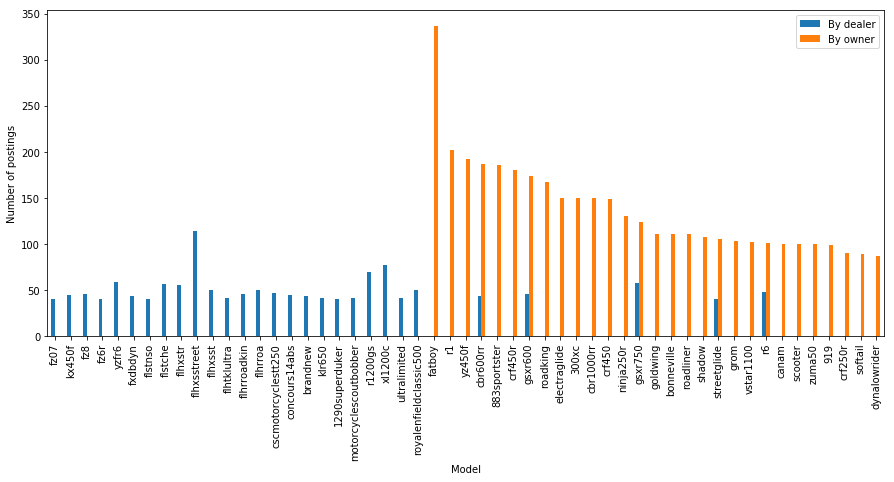

In [29]:
from collections import Counter
import numpy as np

def frequency_counter(df,field,num):  
    curr_list = df[field].tolist()
    counts = Counter(curr_list)
    common_list = counts.most_common(min(num,len(counts)))
    labels = [x[0] for x in common_list if (len(str(x[0]))>0 and x[0]!=None)]
    counts = [x[1] for x in common_list if (len(str(x[0]))>0 and x[0]!=None)] # remove blank strings
    #print(type(labels[0]))
    #print(counts)
    df_out = pd.DataFrame({field: labels, 'counts': counts})
    #print(field)
    return df_out,labels

def make_to_displacement(df,tolerance,num):
    
    curr_list = df['model'].tolist()
    counts = Counter(curr_list)
    print('Number of unique models: %d' % (len(counts)))
    common_list = counts.most_common(min(num,len(counts)))
    models = [x[0] for x in common_list if (len(str(x[0]))>0 and x[0]!=None)]

    for model in models:
        a = df.loc[df['model']==model,'engine displacement (CC): ']
        b = pd.to_numeric(a)
        cc = b[b>0] # filter blank entries
        m = cc.mean()
        s = cc.std()
        if s/m<tolerance:
            df.loc[df['model']==model,'engine displacement (CC): ']=m
    d = len(df.index[df['engine displacement (CC): ']!=0])/len(df.index)        
    print('Displacement categorization: %s' % (d*100))
    return df


df_out,labels = frequency_counter(df_p_owner,'model',50)
df_out,dealer_labels = frequency_counter(df_p_dealer,'model',50)

#print(dealer_labels)



# from labels counted above

dealer_labels = ['flhxsstreet', 'xl1200c', 'r1200gs', 'yzfr6', 'gsxr750',
                 'flstche', 'flhxstr', 'flhrroa', 'flhxsst', 'royalenfieldclassic500',
                 'r6', 'cscmotorcyclestt250', 'fz8', 'flhrroadkin', 'gsxr600',
                 'concours14abs', 'kx450f', 'cbr600rr', 'fxdbdyn', 'brandnew',
                 'klr650', 'motorcyclescoutbobber', 'flhtklultra', 'ultralimited', 'flstnso',
                 'fz07', 'fz6r', 'streetglide', '1290superduker', 'ninja300',
                 'multistrada1200s', 'cbr1000rr', 'ninja300abs', 'r1', 'street',
                 'flhtkultral', 'flhtkel', 'zx6r', 'crf450r', 'cbr650f',
                 'crf250r', 'flhtelectra', 'bonnevillebobber2to', 'lancepowersportshavanaclassic125', 'flhtkul',
                 'xl1200x', 'fxdldyn', 'yzfr1s', 'vespa']

dealer_types = ['cruiser','cruiser','standard','sport','sport',
               'cruiser','cruiser','cruiser','cruiser','standard',
               'sport','dirt','standard','cruiser','sport',
                'cruiser','dirt','sport','cruiser','other',
                'dirt','cruiser','cruiser','cruiser','cruiser',
                'standard','standard','cruiser','standard','standard',
                'standard','sport','standard','sport','standard',
                'cruiser','cruiser','sport','dirt','standard',
                'dirt','cruiser','cruiser','scooter','cruiser',
                'cruiser','cruiser','sport','scooter']

private_owner_labels = ['fatboy', 'r1', 'yz450f', 'cbr600rr', '883sportster',
                        'crf450r', 'gsxr600', 'roadking', 'cbr1000rr', 'electraglide',
                        '300xc', 'crf450', 'ninja250r', 'gsxr750', 'bonneville',                        
                        'goldwing', 'roadliner', 'shadow', 'streetglide', 'grom',
                        'vstar1100', 'r6', 'zuma50', 'canam', 'scooter',
                        '919', 'crf250r', 'softail', 'dynalowrider', 'roadglide',                        
                        's1000rr', '450sxf', 'roadstar', 'ultraclassic', 'ultralimited',
                        'ninja', 'klr650', 'intruder', '450', 'vstar',
                        'kx450f', 'yz250f', 'cb550', 'sportster', 'xl600r',
                        '350exc', 'gsxr', 'gsxr1000', 'drz400']

private_owner_types = ['cruiser','sport','dirt','sport','cruiser',
                      'dirt','sport','cruiser','sport','cruiser',
                      'dirt','dirt','standard','sport','cruiser',                       
                       'cruiser','cruiser','cruiser','cruiser','standard',
                      'cruiser','sport','scooter','other','scooter',
                       'standard','dirt','cruiser','cruiser','cruiser',                       
                       'sport','dirt','cruiser','cruiser','cruiser',
                       'sport','dirt','cruiser','dirt','cruiser',
                      'dirt','dirt','standard','cruiser','dirt',
                      'dirt','sport','sport','standard']



def map_model_to_category(df,labels,types):
    df_out=df
    df_out['Category']=""
    for i in range(len(labels)):
        df_out.loc[df_out['model']==labels[i],'Category']=types[i]
    return df_out

def format_2cat_frequency_noalign(df_p_owner,df_p_dealer,cat,num,norm=1):
      
    df_make_owner,labels = frequency_counter(df_p_owner,cat,num)    
    df_make_dealer,b_labels = frequency_counter(df_p_dealer,cat,num)      
    df_make_owner['Key'] = 'By owner'
    df_make_dealer['Key'] = 'By dealer'
    
    DF = pd.concat([df_make_owner,df_make_dealer],keys = ['By owner','By dealer'])
    
    DFGroup = DF.groupby([cat,'Key'])
    b = DFGroup.sum().unstack('Key')
    c = b['counts']['By owner'] # multi leve indexing - get counts for specific category
    counts = [x for x in c] # make list of counts
    idx = np.argsort(counts)[::-1] # sort in descending order
    make = c.keys()[idx] # re index make list
    c = b.reindex(make[0:]) # re index dataframe according to new make list
    return c


#a = df.loc[df['model']=='r1','engine displacement (CC): ']
#df(a)
df_p_owner1 = make_to_displacement(df_p_owner,0.2,500)
df_p_dealer1 = make_to_displacement(df_p_dealer,0.2,500)


df_cat_owner = map_model_to_category(df_p_owner1,private_owner_labels,private_owner_types)   
df_cat_dealer = map_model_to_category(df_p_dealer1,dealer_labels,dealer_types)           

d = len(df_cat_dealer.index[df_cat_dealer['Category']!=""])/len(df_cat_dealer.index)

print('Dealer categorization: %s' % (d*100))
o = len(df_cat_owner.index[df_cat_owner['Category']!=""])/len(df_cat_owner.index)
print('Owner categorization: %s' % (o*100))

model_list = format_2cat_frequency_noalign(df_p_owner,df_p_dealer,'model',30)
modelPlot = model_list.plot(kind='bar',figsize = (15,6))
modelPlot.legend(["By dealer", "By owner"])
modelPlot.set_ylabel("Number of postings")
modelPlot.set_xlabel("Model")




In [23]:
df_cat_owner.head(10)

,condition:,engine displacement (CC):,latitude,longitude,make,model,odometer:,post title,price,title status:,url,year,area,Category
0,like new,0,36.427564,-121.331015,Harley,,13000,2015 Harley-Davidson,16500,clean,https://bakersfield.craigslist.org/mcy/d/2015-...,2015.0,bakersfield,
1,like new,103,35.339600,-119.021800,Harley,,36906,2013 harley davidson,16500,clean,https://bakersfield.craigslist.org/mcy/d/2013-...,2013.0,bakersfield,
2,0,0,35.410472,-119.026718,None,ironhorsechooper,0,2005 ironhorse chooper,3000,0,https://bakersfield.craigslist.org/mcy/d/2005-...,2005.0,bakersfield,
3,excellent,1500,35.148200,-119.455700,Kawasaki,vulcan1500,20348,1991 kawasaki vulcan 1500,2500,clean,https://bakersfield.craigslist.org/mcy/d/1991-...,1991.0,bakersfield,
4,excellent,0,0.000000,0.000000,Honda,xr70,0,2002 Honda xr70,920,0,https://bakersfield.craigslist.org/mcy/d/2002-...,2002.0,bakersfield,
5,0,0,35.163260,-119.046324,None,willysjeep,0,willys jeep,15000,0,https://bakersfield.craigslist.org/mcy/d/stree...,NaN,bakersfield,
6,like new,900,35.132200,-118.449000,Kawasaki,vulcan900classic,2903,Kawasaki Vulcan 900 Classic,3800,0,https://bakersfield.craigslist.org/mcy/d/2006-...,NaN,bakersfield,
7,new,999.966,0.000000,0.000000,BMW,s1000rr,2400,2012 bmw s1000rr,13000,clean,https://bakersfield.craigslist.org/mcy/d/bmw-s...,2012.0,bakersfield,sport
8,new,0,33.799100,-117.995600,Honda,919,0,2007 Honda 919,5000,clean,https://bakersfield.craigslist.org/mcy/d/2007-...,2007.0,bakersfield,standard
9,good,0,35.463637,-118.789785,None,bonanzabc1500modified,0,1969 Bonanza BC 1500 Modified,750,0,https://bakersfield.craigslist.org/mcy/d/1969-...,1969.0,bakersfield,


### Frequency of model listings
We now have a relatively complete dataset for our craigslist search.  Now we can begin to address our dealership startup scenario by answering the following: 
- Which makes and types of motorcycles show the greatest market demand, relative to dealer offerings? 
- Which makes and types have the highest potential profit margins?
- Which areas of the state are underserved?

Here, market demand relative to dealer offerings is defined by the difference between number of private postings and number of dealer postings, for each category analyzed below.  Dealer and private post counts are normalized by the total postings across the entire state (~8000 dealer and ~24000 private postings).

Similarly, potential profit margin is defined as the difference in average list price for each category.  Total profit potential is defined as the sum of list prices for all bikes in each category.

#### Assumptions:
Unfortunately, while we can see when motorcycles are listed for sale on craigslist, we have no direct way of determining a) when they're sold, and b) how much they're sold for.  Bikes that sell rapidly have high market demand, yet may have low post volume at any one time.  On the other hand, bikes that are difficult to sell may have a high post volume, and low demand. List prices may accurately represent sale prices for dealer listings, but private sales often involve behind-the-scenes negotiation.  As such, interpretation of the available data makes two main assumptions:

- For point a), we assume that post volume is proportional to demand
- For point b), we assume that list price is equivalent to sale price

Text(0,0.5,'Number of postings')

Text(0.5,0,'Make')

Text(0,0.5,'Number of postings')

Text(0.5,0,'Model')

Text(0,0.5,'Number of postings')

Text(0.5,0,'Category')

Text(0,0.5,'Number of postings')

Text(0.5,0,'Area')

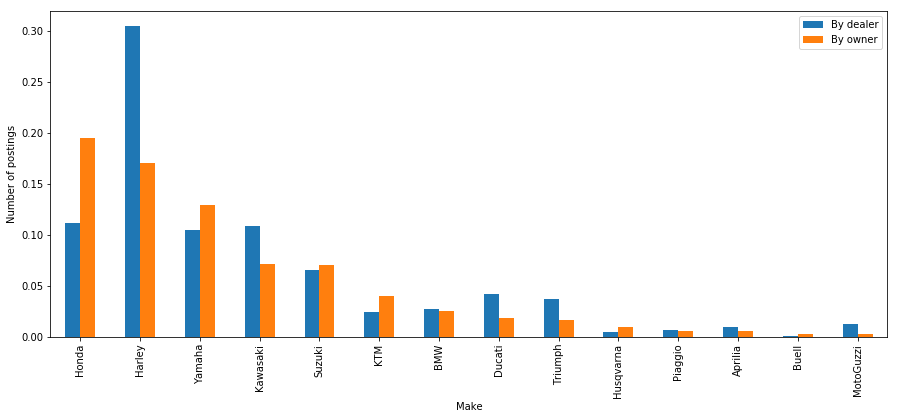

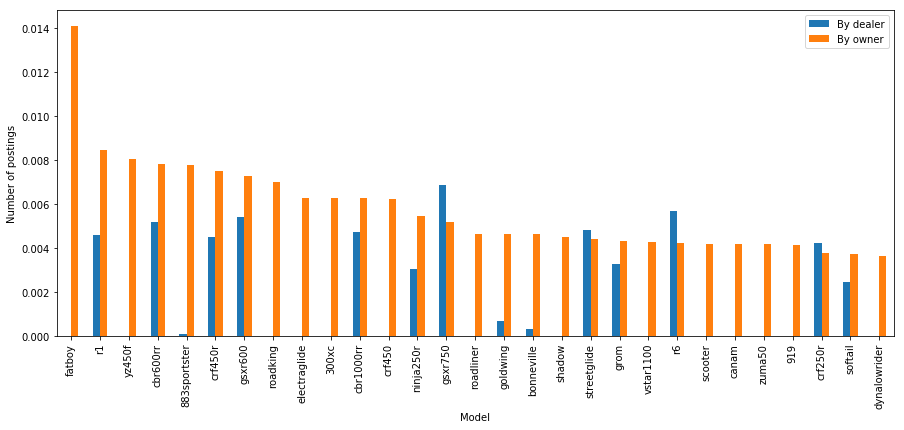

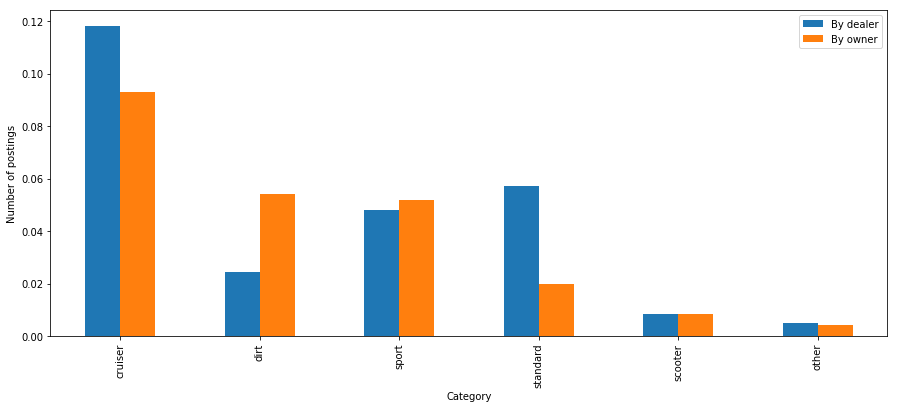

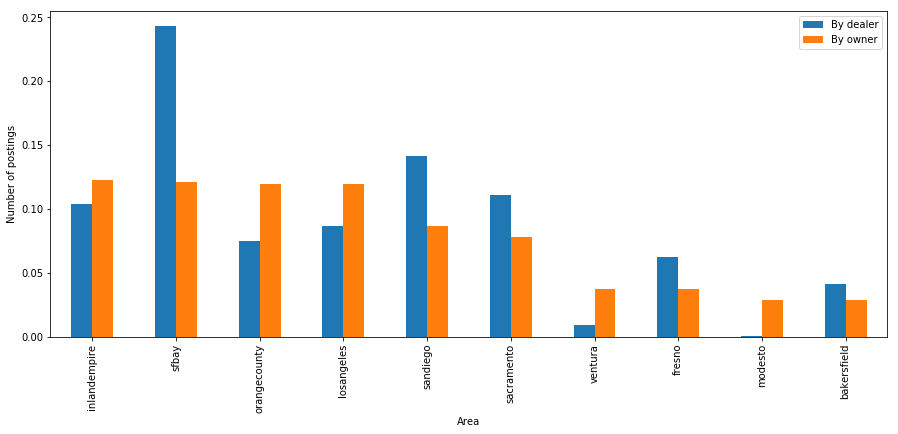

In [30]:


# return dataframe to make bar plot
# skipStart = 1 to skip first category (unlabeled/none), 0 otherwise


                                     
# for string comprehension and counting
def format_2cat_frequency(df_p_owner,df_p_dealer,cat,num,norm=1):
    
    dealer_num = df_p_dealer.shape[0]
    owner_num = df_p_owner.shape[0]    
    df_make_owner,labels = frequency_counter(df_p_owner,cat,num)    
    df_make_dealer = df_p_dealer.loc[df_p_dealer[cat].isin(labels)]
    df_count = df_make_dealer[cat].tolist()
    c = dict(Counter(df_count))
    counts=[]
    for x in labels:
        if x in c:
            count = c[x]
            counts.append(count)
        else:
            counts.append(0)        
    df_out = pd.DataFrame({cat: labels, 'counts': counts})  
    
    df_make_owner['Key'] = 'By owner'
    df_out['Key'] = 'By dealer'
    
    if norm==1:  #scale by total postings for each category
        
        df_out['counts']=df_out['counts']/dealer_num
        df_make_owner['counts']=df_make_owner['counts']/owner_num
    
    DF = pd.concat([df_make_owner,df_out],keys = ['By owner','By dealer'])
    
    DFGroup = DF.groupby([cat,'Key'])
    b = DFGroup.sum().unstack('Key')
    c = b['counts']['By owner'] # multi leve indexing - get counts for specific category
    counts = [x for x in c] # make list of counts
    idx = np.argsort(counts)[::-1] # sort in descending order
    make = c.keys()[idx] # re index make list
    c = b.reindex(make[0:]) # re index dataframe according to new make list
    return c
#make_new = make.reindex(idx)
#make_new
#b.reindex(idx)
#b
# cat='make'
# df_make_owner,labels = frequency_counter(df_p_owner,cat,15)

# df_make_dealer = df_p_dealer.loc[df_p_dealer[cat].isin(labels)]


# df_count = df_make_dealer[cat].tolist()
# #print(df_count)
# counts = dict(Counter(df_count))
# counts1 = [counts[x] for x in labels]

# print(counts1)

#df_out = pd.DataFrame({field: labels, 'counts': counts}) 


#df2 = frequency_counter(df_p_owner,'model',30)
#field = 'model'
#df2 = pd.DataFrame({field: labels, 'counts': counts})   

make_list = format_2cat_frequency(df_cat_owner,df_cat_dealer,'make',15)
model_list =format_2cat_frequency(df_cat_owner,df_cat_dealer,'model',30)
category_list =format_2cat_frequency(df_cat_owner,df_cat_dealer,'Category',10)
area_list =format_2cat_frequency(df_cat_owner,df_cat_dealer,'area',10)
#model_list2,c3 =format_2cat_frequency(df_p_dealer,df_p_owner,'model',30)


makePlot = make_list.plot(kind='bar',figsize = (15,6))
makePlot.legend(["By dealer", "By owner"])
makePlot.set_ylabel("Number of postings")
makePlot.set_xlabel("Make")

modelPlot = model_list.plot(kind='bar',figsize = (15,6))
modelPlot.legend(["By dealer", "By owner"])
modelPlot.set_ylabel("Number of postings")
modelPlot.set_xlabel("Model")

categoryPlot = category_list.plot(kind='bar',figsize = (15,6))
categoryPlot.legend(["By dealer", "By owner"])
categoryPlot.set_ylabel("Number of postings")
categoryPlot.set_xlabel("Category")

areaPlot = area_list.plot(kind='bar',figsize = (15,6))
areaPlot.legend(["By dealer", "By owner"])
areaPlot.set_ylabel("Number of postings")
areaPlot.set_xlabel("Area")

# modelPlot = model_list.plot(kind='bar',figsize = (15,6))
# modelPlot.legend(["By dealer", "By owner"])
# modelPlot.set_ylabel("Number of postings")
# modelPlot.set_xlabel("Model")

# diff = make_list['counts']['By owner']-make_list['counts']['By dealer']
# idx_use = np.where(make_list['counts']['By owner']>100) # min 100 postings


# d = diff.to_frame()
# e = d.iloc[idx_use[0],:]

# ratio_plot = e.plot(kind='bar',figsize = (18,6),legend=False)
# ratio_plot.set_title("Market room for dealer sales")
# ratio_plot.set_ylabel("Private sale excess")
# ratio_plot.set_xlabel("Make")



# ratio_plot.set_ylim(0,1)
# DF2[0]
#df_try['Key']
#df_try.index.get_level_values(1)

#DFGroup.sum().to_pickle('C:/Users/sam/jupyter/combined.pkl')
#DFGPlot = DFGroup.sum().unstack('Key').plot(kind='bar')
#DFGPlot = DFGroup.sum().unstack('Key').plot(kind='bar')
#df4 = frequency_counter(df2,'model',50,1)
#df3
#a = df3.plot.bar(x='model',y='counts',figsize = (15,6))
#b = df4.plot.bar(x='makes',y='counts',figsize = (15,6))
#df2
#df3


0

### Pricing by make and bike category
From the data above, we can get an idea of which makes and categories to focus on.  Japanese bikes, particularly Honda and Yamaha, have a combination of high post volume and relatively sparse dealer listings.  Dirt and sportbikes also seem to be the most underserved by the dealer segment.  Conversely, Harleys, cruisers, and standard motorcycles are the bread and butter of dealer offerings.

From the analysis of post areas, southern california, including the inland empire, OC, and LA seem to have the highest potential for additional dealer presence.  Meanwhile, the bay area is strongly represented in the dealer space, and would likely be a bad candidate.

#### Now, let's look deeper into the areas of interest we've identified:
- Can we pinpoint specific areas which have the highest dealer need?
- For each category, which years have the highest profit potential?

#### Plotting a heatmap of available GPS coordinates reveals hotspots of owner and dealer listings:

By owner:
<img src="files/owner.png">


By dealer:
<img src="files/dealer.png">


And finally, we can plot only the private listings with no nearby dealer listings to get a sense of which areas are underserved:
<img src="files/no_nearby_dealers.png">

In [40]:
#######################################
# extract GPS coords and plot heatmap #
#######################################

import gmplot
import scipy.spatial

def deg_to_radians(deg):
    r = deg*np.pi/180
    return r

def gps_dist(lat1,long1,lat2,long2):
    r = 6371000 # radius of earth in meters
    t1 = deg_to_radians(lat1)
    t2 = deg_to_radians(lat2)
    d1 = deg_to_radians(lat2-lat1)
    d2 = deg_to_radians(long2-long1)    
    a = (np.sin(d1/2)*np.sin(d1/2) +
        np.cos(t1)*np.cos(t2)*np.sin(d2/2)*np.sin(d2/2))
    b = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    c = r*b
    return c # in meters

# for each private posting, calculate number of dealer postings within distance threshold

def find_nearest_neighbors(list1,list2,dist_thresh): # find # of neighbors in list2 
    num_list = []
    if list1.shape[0]==2:
        list1 = np.transpose(list1)
    if list2.shape[0]==2:
        list2 = np.transpose(list2)
    dist_mat = scipy.spatial.distance.cdist(list1,list2,'euclidean')
    dist_mat = dist_mat*111000 # convert from lat/long to meters
    for i in range(dist_mat.shape[0]):
        num = np.where(dist_mat[i][:]<dist_thresh)
        num = len(num[0])
        num_list.append(num)
    return np.array(num_list)
            

gmap = gmplot.GoogleMapPlotter(36.428, -120.145, 6)

lat = df_cat_owner['latitude'].tolist()
long = df_cat_owner['longitude'].tolist()
lat1 = df_cat_dealer['latitude'].tolist()
long1 = df_cat_dealer['longitude'].tolist()

lat_o = np.asarray([x for x in lat if x!=0])
long_o = np.asarray([x for x in long if x!=0])
coords_o = np.stack((lat_o,long_o))


lat_d = np.asarray([x for x in lat1 if x!=0])
long_d = np.asarray([x for x in long1 if x!=0])
coords_d = np.stack((lat_d,long_d))
# find # of points in list 2 within threshold distance for each point in list 1

num_list = find_nearest_neighbors(coords_o,coords_d,50000) # find listings with no dealer post within 50 km
idx_use = np.where(num_list==0)
lat_o_filter = lat_o[idx_use]
long_o_filter = long_o[idx_use]

gmap.heatmap(lat_o,long_o)
gmap.draw("owner.html")

In [42]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
#####################
# plot with seaborn #
#####################

def bin_stats(x,y,bins):
    
    x_mean_out=[]
    y_mean_out=[]
    x_sem_out=[]
    y_sem_out=[]
    num_out = []
    
    for i in range(len(bins)-1):
        idx_use = np.where((x>=bins[i]) & (x<bins[i+1]))[0]
        n = len(idx_use)
        ns = np.sqrt(n)
        x_use = x[idx_use]
        y_use = y[idx_use]
        x_mean = np.mean(x_use)
        y_mean = np.mean(y_use)
        x_sem = np.std(x_use)/ns
        y_sem = np.std(y_use)/ns
        x_mean_out.append(x_mean)
        y_mean_out.append(y_mean)
        x_sem_out.append(x_sem)
        y_sem_out.append(y_sem)
        num_out.append(n)
    return x_mean_out, y_mean_out, x_sem_out, y_sem_out, num_out


def filter_by_year_and_price(df,pr,field,cat):  #[500,20000] - gives indices of valid year and price
    df2 = df.loc[(df[field]==cat) & (df['price']>pr[0]) & (df['price']<=pr[1]) & (df['year']>1960)] 
    price = np.array(df2['price'].tolist())
    year = np.array(df2['year'].tolist())
    return price, year


# df_out = frequency_counter(df_p_owner,'make',15,0)
# df_filter = df_out[df_out['make'].notna()]
# make_list_use = df_filter['make'].tolist()
# df2 = df_p_owner.loc[df_p_owner['make']=='Honda']

p1,y1 = filter_by_year_and_price(df_cat_owner,[500,20000],'make','Honda')
p1d,y1d = filter_by_year_and_price(df_cat_dealer,[500,20000],'make','Honda')

p1,y1 = filter_by_year_and_price(df_cat_owner,[500,20000],'Category','cruiser')
p1d,y1d = filter_by_year_and_price(df_cat_dealer,[500,20000],'Category','cruiser')

#p2,y2 = filter_by_year_and_price(df_p_owner,[500,20000],'gsxr600')

#price_use = np.array(df2['price'].tolist())
#year_use = np.array(df2['year'].tolist())


#df2


#price_filter_idx_dealer = filter_by_year_and_price(df_dealer,[500,20000])
#price_filter_idx_owner = filter_by_year_and_price(df,[500,20000])

#year_list_filter_dealer = get_year_list(df_dealer)[price_filter_idx_dealer]
#price_list_filter_dealer = np.array(df_dealer['price'].tolist())[price_filter_idx_dealer]

#year_list_filter_owner = get_year_list(df)[price_filter_idx_owner]
#price_list_filter_owner = np.array(df['price'].tolist())[price_filter_idx_owner]


#price_list_filter = p[price_filter_idx]
#year_list_int = year_list_filter.astype(int)

#print(type(price_list_filter))
ybins = np.linspace(1990, 2018, num=10)
#print(bins)
#print(range(ybins))
# x,y,a,b = bin_stats(y1,p1,ybins)
# xd,yd,ad,bd = bin_stats(y1d,p1d,ybins)

# y_sub = [a_i - b_i for a_i, b_i in zip(yd, y)]


# print(len(y1d))
# print(len(y1))

df, labels = frequency_counter(df_cat_owner,'Category',10)
#print(labels)


    
colors = ['aliceblue','aqua','brown','cornsilk','crimson','darkgoldenrod']
def plot_multiple_lines(df,df2,field,num,title,scale=0):
    df5, labels = frequency_counter(df,field,num)
    sns.set()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    fig = plt.figure()
    fig.set_size_inches(15, 6)
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel('Year')
    
    for label in labels:
        p1,y1 = filter_by_year_and_price(df,[500,20000],field,label)
        p1d,y1d = filter_by_year_and_price(df2,[500,20000],field,label)
        ybins = np.linspace(1990, 2018, num=10)
        x,y,a,b,n = bin_stats(y1,p1,ybins)
        xd,yd,ad,bd,nd = bin_stats(y1d,p1d,ybins)
        y_sub = [a_i - b_i for a_i, b_i in zip(yd, y)]
        n_sub = [a_i - b_i for a_i, b_i in zip(n, nd)]
        y_scale = [a_i * b_i for a_i, b_i in zip(y_sub, n_sub)]
        
        
####### plotting stuff

        if scale==1:
            ax.plot(x, y_scale,label=label)
            ytitle = 'Total price potential ($)'
            #print(n_sub)
        else:
    #ax.scatter(x,y)
    #ax.errorbar(x, y_sub, xerr=a, yerr=b,color='g',label='Honda pricing - by owner')
            ax.plot(x, y_sub,label=label)
            ytitle = 'Listed price difference ($)'
        #ax.errorbar(xd, yd, xerr=ad, yerr=bd,color='b',label='Honda pricing - by dealer')
    ax.legend(loc='upper left')
    ax.set_ylabel(ytitle)
    plt.show()
    
    return None

Finally, let's investigate the price dependence on model year for each category investigated above, and try to pinpoint an age range to focus on:


C:\Users\asdasdasd\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\asdasdasd\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\asdasdasd\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\asdasdasd\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\asdasdasd\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


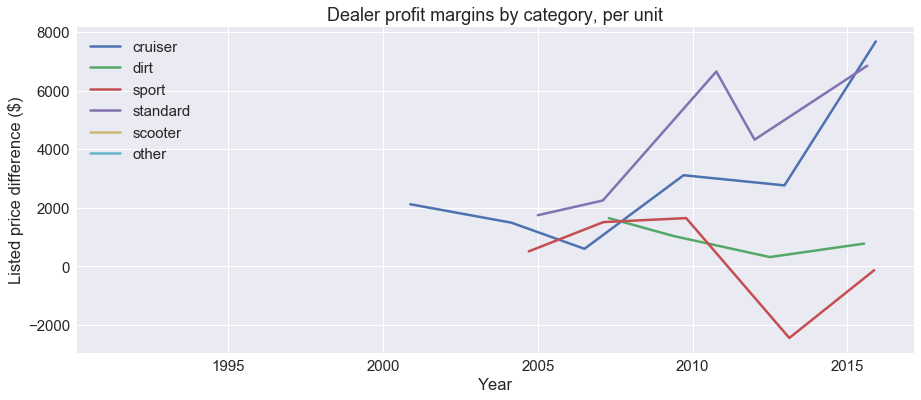

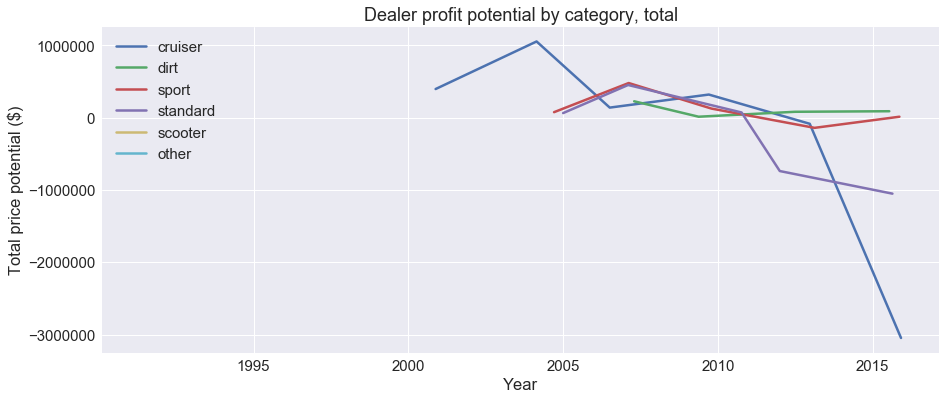

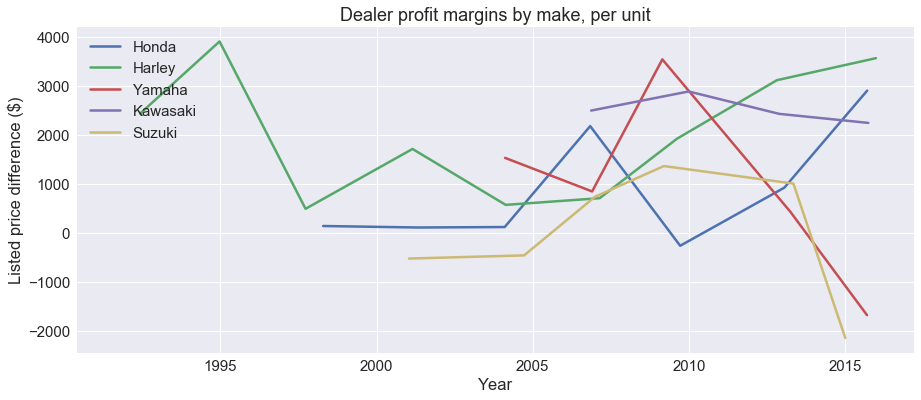

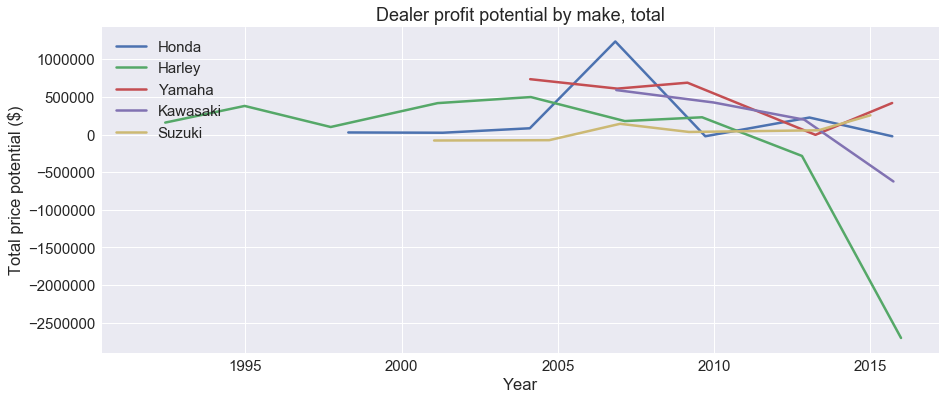

In [43]:
plot_multiple_lines(df_cat_owner,df_cat_dealer,'Category',10,'Dealer profit margins by category, per unit',scale=0)
plot_multiple_lines(df_cat_owner,df_cat_dealer,'Category',10,'Dealer profit potential by category, total',scale=1)
plot_multiple_lines(df_cat_owner,df_cat_dealer,'make',6,'Dealer profit margins by make, per unit',scale=0)
plot_multiple_lines(df_cat_owner,df_cat_dealer,'make',6,'Dealer profit potential by make, total',scale=1)
# #sns.axes_style()

#print(b.tolist())
#c = np.where(condition,b)

### Conclusions:
Based on the analysis above, my proposed dealership would:
- Be located near one of the hotspots identified with an underserved market (Santa Barbara, central valley, socal)
- Specialize in Japanese brands (Honda, Yamaha, Kawasaki), especially for model years 2005-2010
- Focus primarily on dirt and sportbikes


### Next steps:
#### Scrape results on a regular basis to enable time-dependent insights:
- Tracking the same post over time and identifying when it's taken down can enable a more accurate determination of market demand and sale price
- Analysis of sale price trends over time can help pinpoint the best time to buy and sell
- Collection of averaged data over multiple scraping sessions will net many times more data, enabling more precise data analysis (e.g. looking at specific models, looking at best profit margins in each region, etc.)

#### Expand to a nationwide search
- Can evalate most profitable segments in each region, based on regional preferences
- Could envision a business which transports bikes from a low- to a high-price region

#### Linear regression price prediction model
- Can quickly evaluate and purchase motorcycles under market value
- Can select ads which have the highest profit potential